In [1]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

2024-11-10 15:26:24.055900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 15:26:24.403805: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 15:26:24.405467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 15:26:26.253237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
directory = "./data/img_align_celeba/" 
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = directory, 
                                                    color_mode="rgb", 
                                                    batch_size=128, 
                                                    image_size=(32,32), 
                                                    label_mode=None,
                                                    shuffle=True, 
                                                    seed=42)

Found 202599 files belonging to 1 classes.


2024-11-10 15:26:36.949654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 15:26:36.954900: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
dataset = dataset.map(lambda x:x/255.00)

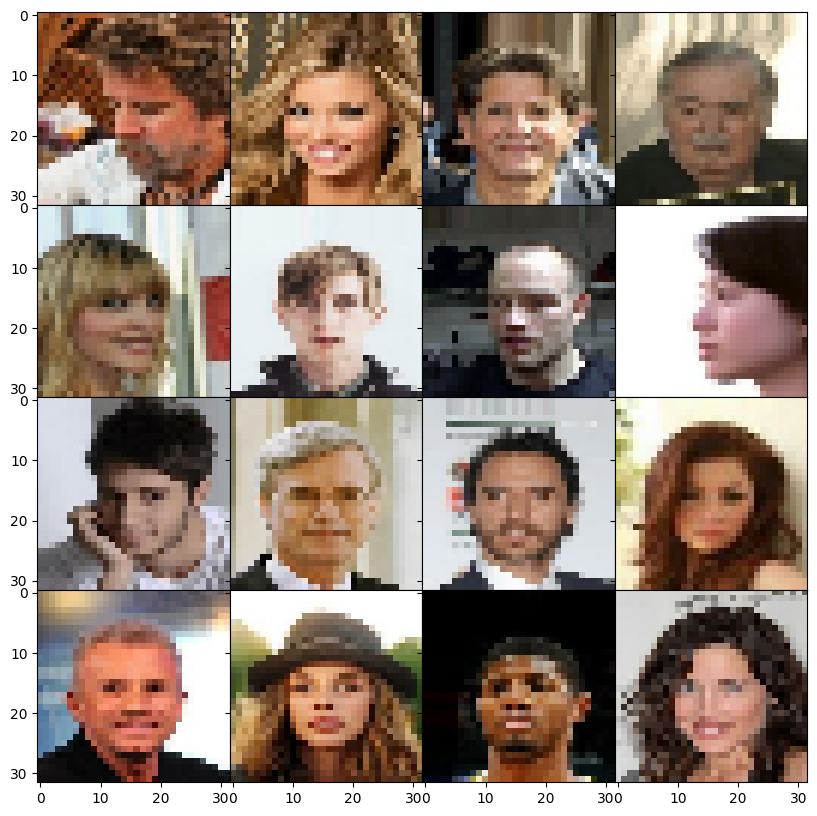

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

it = iter(dataset)
batch1 = next(it).numpy()
images = batch1[:16,:,:,:]

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0)

for ax,im in zip(grid, images):
    ax.imshow(im)
    
plt.show()

In [5]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras import Model, Input


def discriminator_model():
    disc_input = Input(shape = (32,32,3), name = 'disc_network')
    x = Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding ='same')(disc_input)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding ='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding ='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding ='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    output = Activation('sigmoid')(x)

    disc = Model(inputs = disc_input, outputs = output)

    return disc


In [6]:
model = discriminator_model()
model.summary(0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 disc_network (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0     

In [7]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input
def generator_model(z_dim=100):
    gen_input = Input(shape=(z_dim), name='generator_network')
    
    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8,8,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
        
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding='same')(x)
    fake_images_gen = LeakyReLU()(x)
    
    model_gen=Model(inputs = gen_input, outputs=fake_images_gen)
    
    return model_gen

In [8]:
gen_model = generator_model()

In [9]:
gen_model.summary(0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_network (InputLa  [(None, 100)]             0         
 yer)                                                            
                                                                 
 dense_1 (Dense)             (None, 192)               19392     
                                                                 
 reshape (Reshape)           (None, 8, 8, 3)           0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 3)           12        
 Normalization)                                                  
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 3)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         1433

In [10]:
disc_model = discriminator_model()
gen_model = generator_model()

disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
z_dim = 100
disc_model.trainable = False
model_input = Input(shape=(z_dim), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1)) 
    
    disc_model.train_on_batch(batch, valid)
    
    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image, fake)

    
def train_generator(batch_size):
    valid = np.ones((batch_size, 1)) 
    noise = np.random.normal(0,1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)

In [13]:
def save_image(fake_image, path):
    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)
    return image
def generate_and_save_image(path):
    noise = np.random.normal(0,1, (1, z_dim))
    fake_images = gen_model(noise)
    image = save_image(fake_images[0], path)
    plt.imshow(image)
    plt.show()

No of Epochs-> 0


2024-11-10 15:27:57.930030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30670848 exceeds 10% of free system memory.


1/4 [======>.......................] - ETA: 2s

2024-11-10 15:27:58.200973: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-11-10 15:27:58.201199: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20054016 exceeds 10% of free system memory.
2024-11-10 15:27:58.240739: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-11-10 15:27:58.379097: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30670848 exceeds 10% of free system memory.


4/4 [==============================] - 2s 484ms/step
Batch Images-> 0


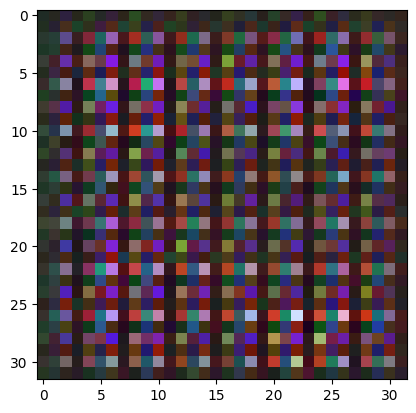

4/4 [==============================] - 2s 426ms/step
Batch Images-> 100


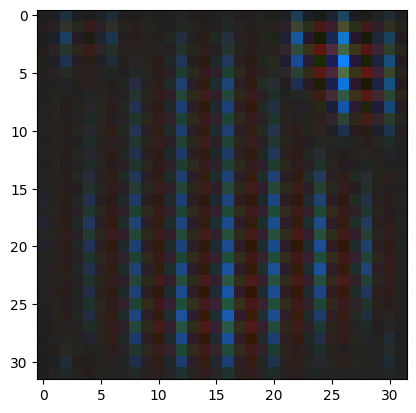

4/4 [==============================] - 1s 132ms/step
Batch Images-> 200


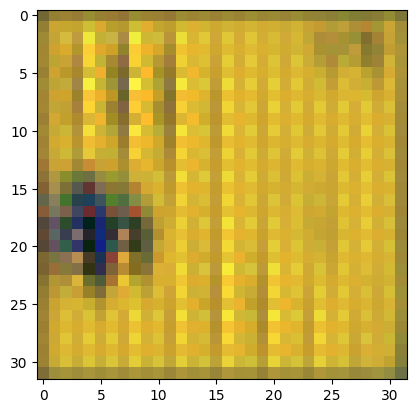

4/4 [==============================] - 2s 449ms/step
Batch Images-> 300


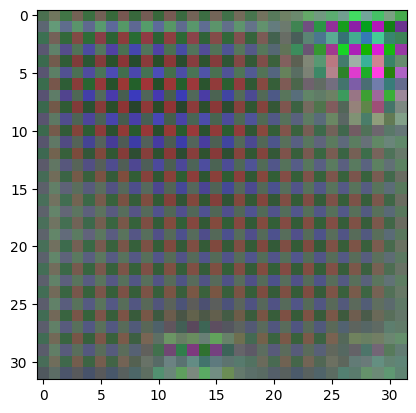

4/4 [==============================] - 2s 422ms/step
Batch Images-> 400


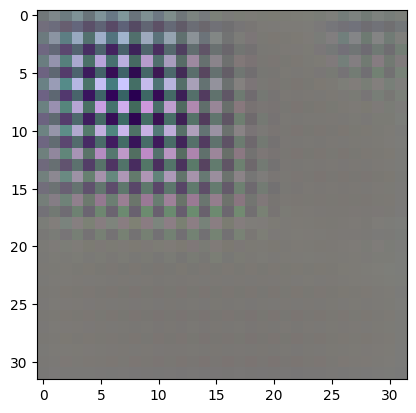

4/4 [==============================] - 1s 133ms/step
Batch Images-> 500


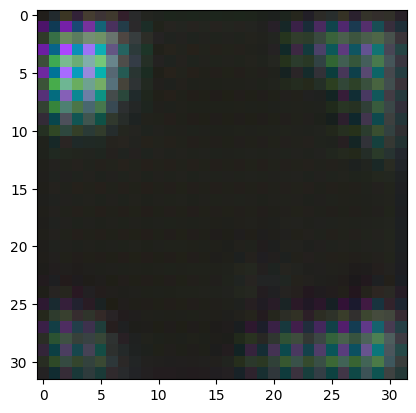

4/4 [==============================] - 1s 127ms/step
Batch Images-> 600


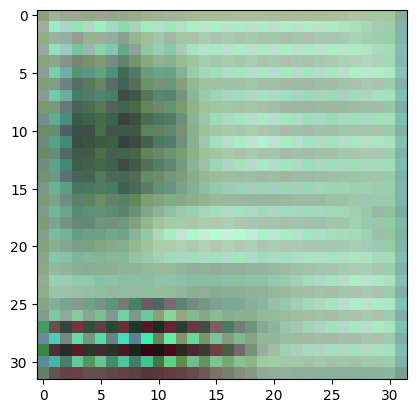

4/4 [==============================] - 1s 130ms/step
Batch Images-> 700


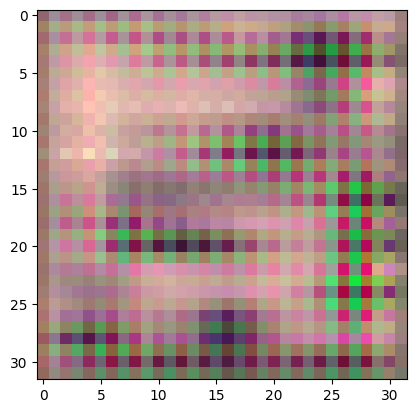

4/4 [==============================] - 1s 134ms/step
Batch Images-> 800


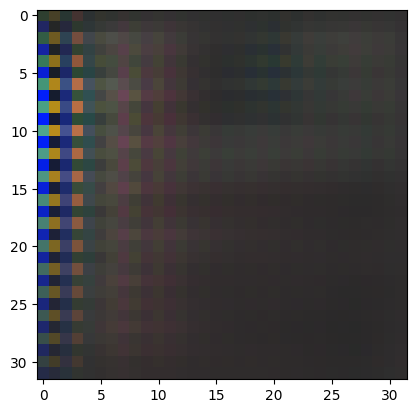

4/4 [==============================] - 1s 134ms/step
Batch Images-> 900


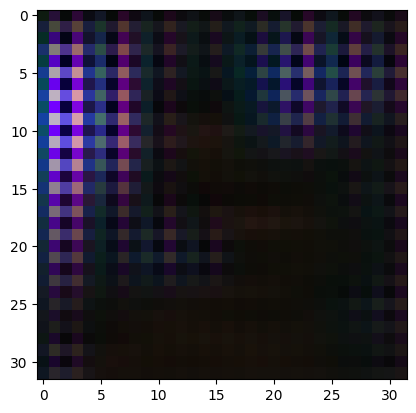

4/4 [==============================] - 1s 126ms/step
Batch Images-> 1000


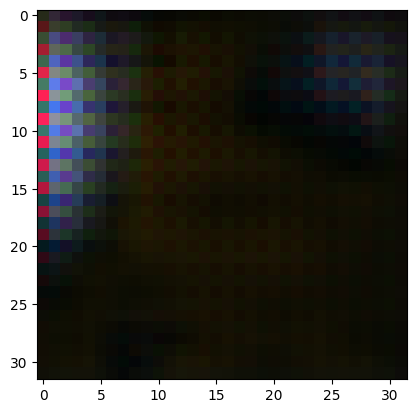

4/4 [==============================] - 1s 222ms/step
Batch Images-> 1100


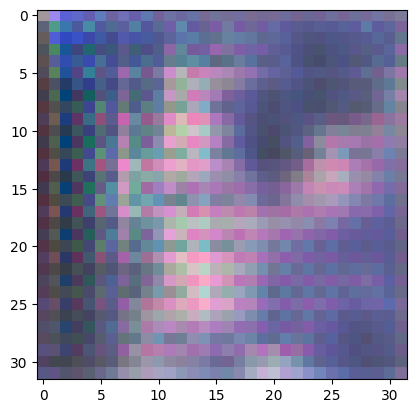

4/4 [==============================] - 1s 272ms/step
Batch Images-> 1200


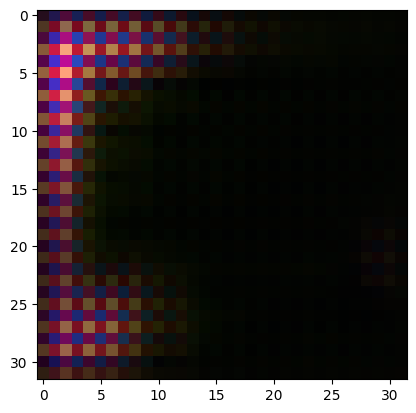

4/4 [==============================] - 1s 234ms/step
Batch Images-> 1300


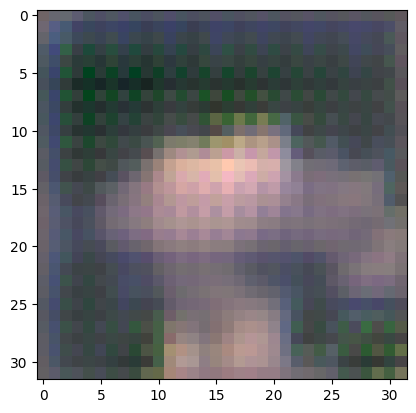

4/4 [==============================] - 1s 130ms/step
Batch Images-> 1400


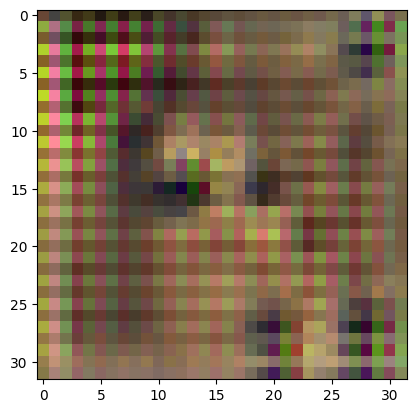

4/4 [==============================] - 1s 131ms/step
Batch Images-> 1500


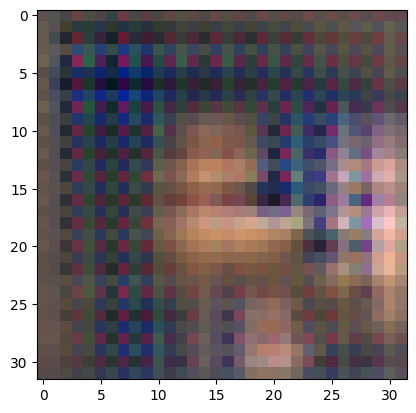

4/4 [==============================] - 1s 152ms/step
No of Epochs-> 1
4/4 [==============================] - 1s 190ms/step
Batch Images-> 0


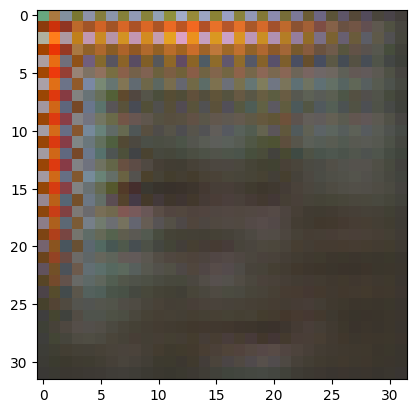

4/4 [==============================] - 1s 241ms/step
Batch Images-> 100


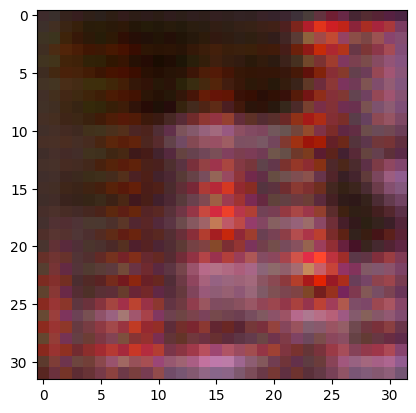

4/4 [==============================] - 1s 262ms/step
Batch Images-> 200


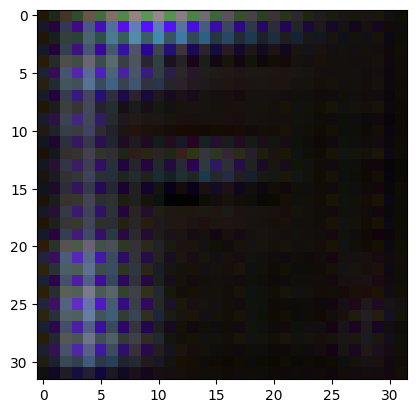

4/4 [==============================] - 1s 221ms/step
Batch Images-> 300


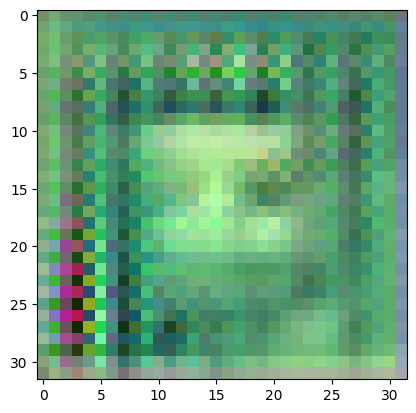

4/4 [==============================] - 1s 126ms/step
Batch Images-> 400


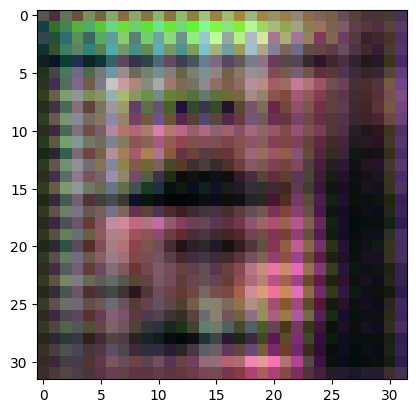

4/4 [==============================] - 1s 125ms/step
Batch Images-> 500


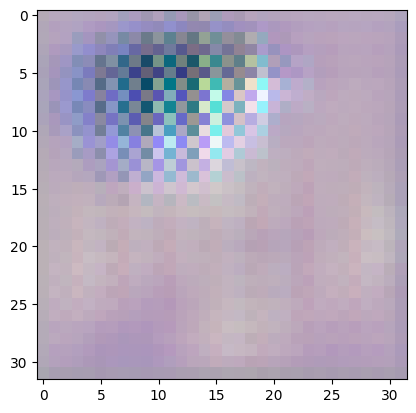

4/4 [==============================] - 1s 193ms/step
Batch Images-> 600


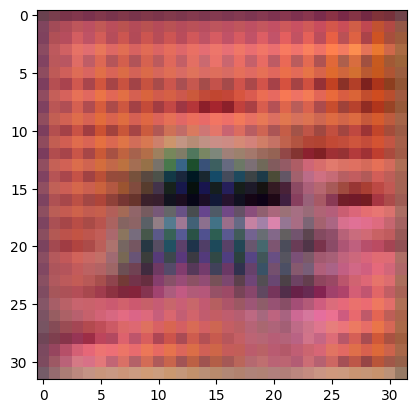

4/4 [==============================] - 1s 218ms/step
Batch Images-> 700


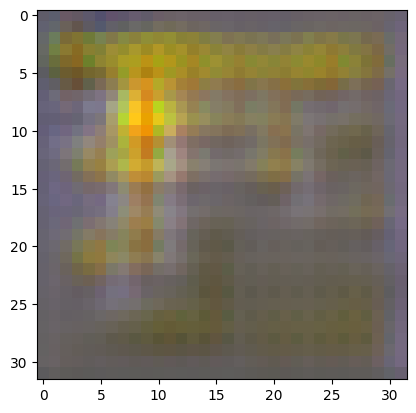

4/4 [==============================] - 1s 206ms/step
Batch Images-> 800


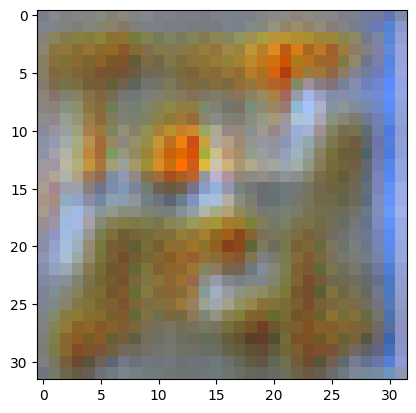

4/4 [==============================] - 1s 204ms/step
Batch Images-> 900


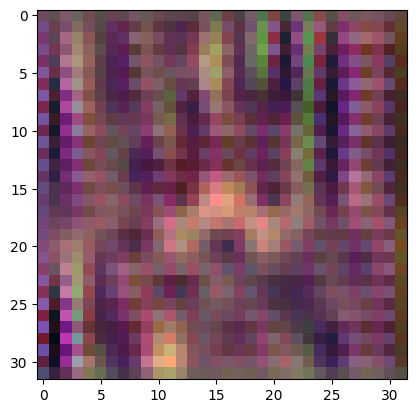

4/4 [==============================] - 1s 134ms/step
Batch Images-> 1000


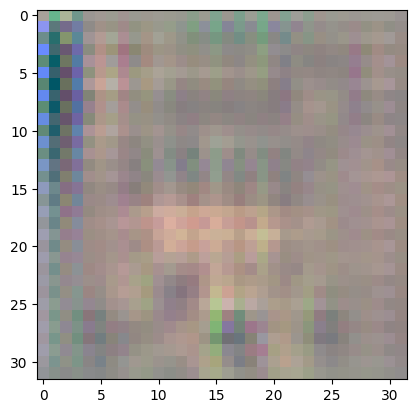

4/4 [==============================] - 1s 127ms/step
Batch Images-> 1100


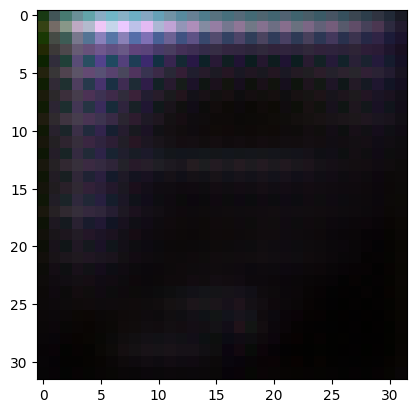

4/4 [==============================] - 1s 130ms/step
Batch Images-> 1200


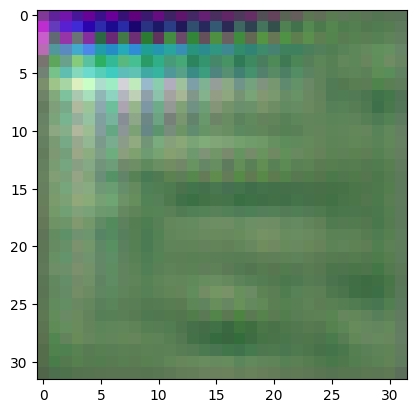

4/4 [==============================] - 1s 130ms/step
Batch Images-> 1300


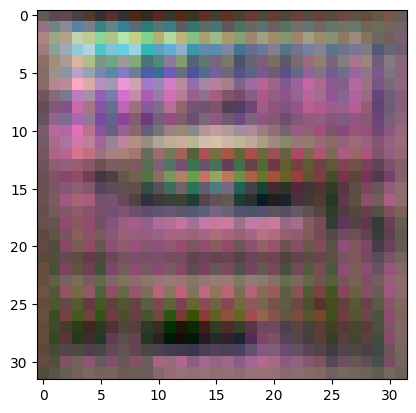

4/4 [==============================] - 1s 222ms/step
Batch Images-> 1400


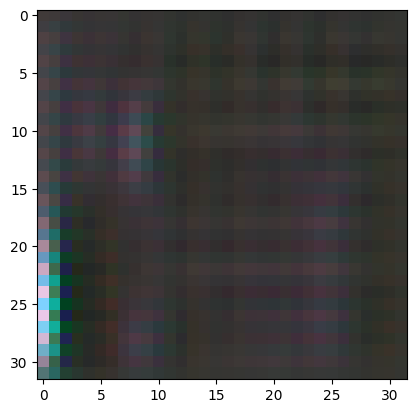

4/4 [==============================] - 1s 215ms/step
Batch Images-> 1500


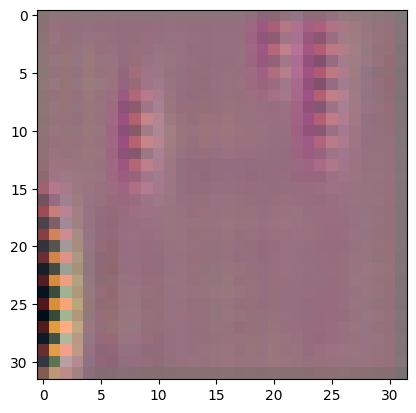

4/4 [==============================] - 0s 95ms/step
No of Epochs-> 2
4/4 [==============================] - 1s 133ms/step
Batch Images-> 0


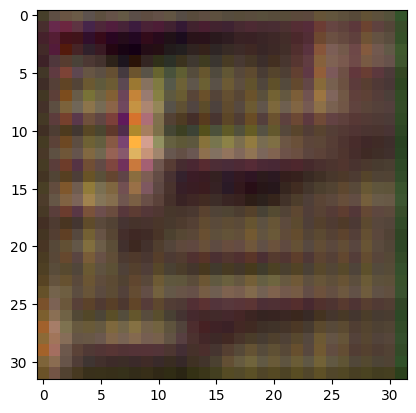

4/4 [==============================] - 1s 146ms/step
Batch Images-> 100


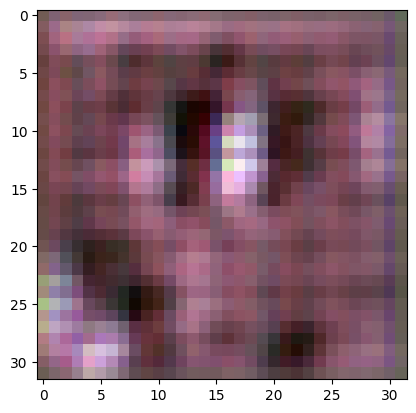

4/4 [==============================] - 1s 132ms/step
Batch Images-> 200


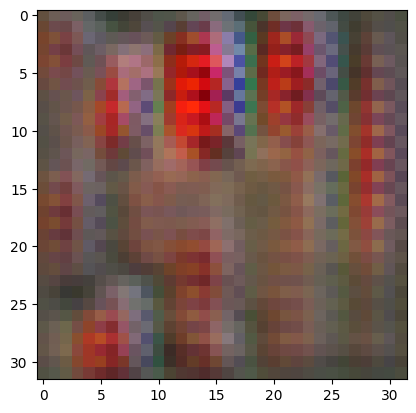

4/4 [==============================] - 1s 137ms/step
Batch Images-> 300


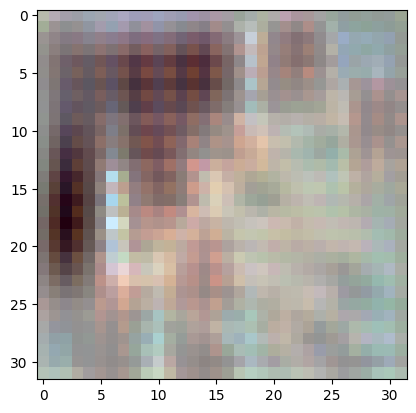

4/4 [==============================] - 1s 124ms/step
Batch Images-> 400


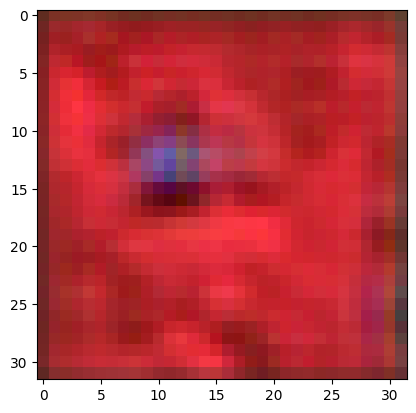

4/4 [==============================] - 1s 134ms/step
Batch Images-> 500


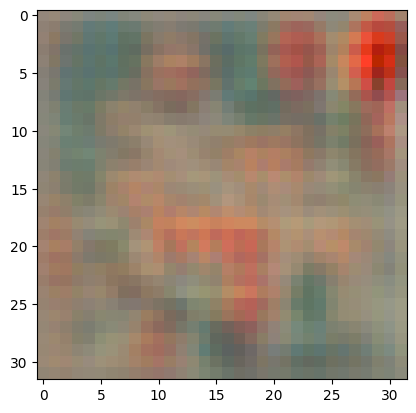

4/4 [==============================] - 1s 266ms/step
Batch Images-> 600


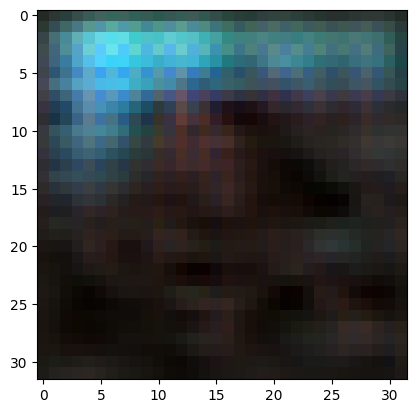

4/4 [==============================] - 1s 250ms/step
Batch Images-> 700


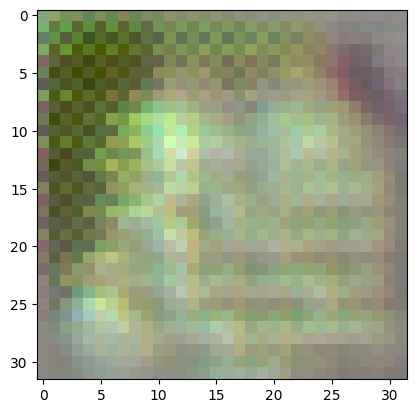

4/4 [==============================] - 1s 128ms/step
Batch Images-> 800


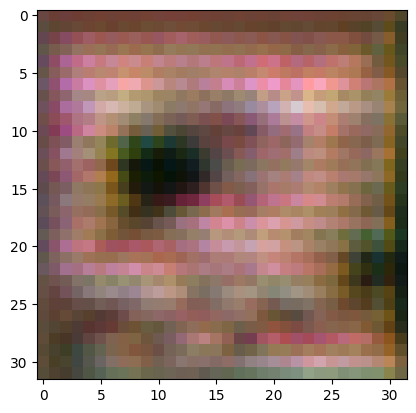

4/4 [==============================] - 1s 124ms/step
Batch Images-> 900


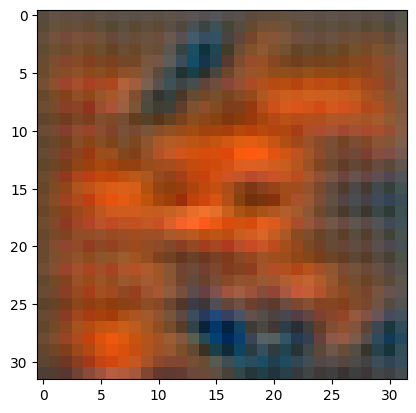

4/4 [==============================] - 1s 136ms/step
Batch Images-> 1000


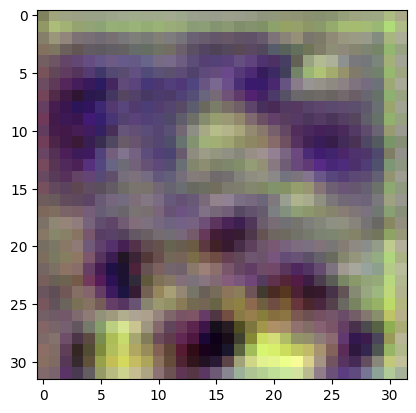

4/4 [==============================] - 1s 131ms/step
Batch Images-> 1100


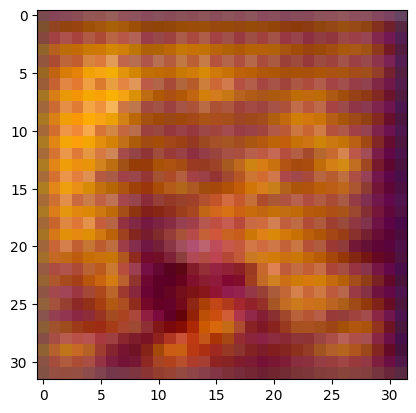

4/4 [==============================] - 1s 268ms/step
Batch Images-> 1200


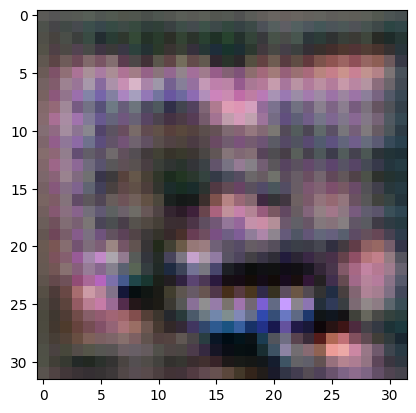

4/4 [==============================] - 1s 128ms/step
Batch Images-> 1300


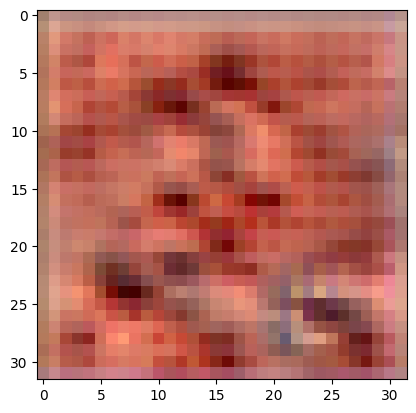

4/4 [==============================] - 1s 132ms/step
Batch Images-> 1400


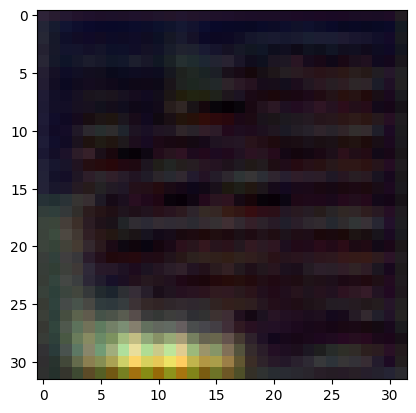

4/4 [==============================] - 1s 131ms/step
Batch Images-> 1500


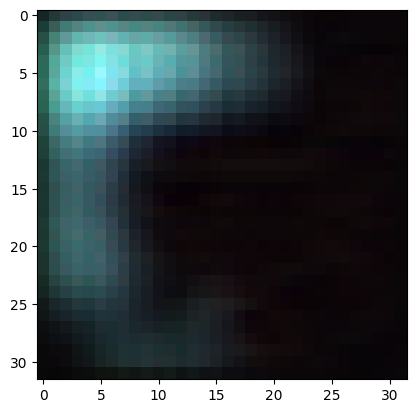

4/4 [==============================] - 1s 186ms/step
No of Epochs-> 3
4/4 [==============================] - 1s 213ms/step
Batch Images-> 0


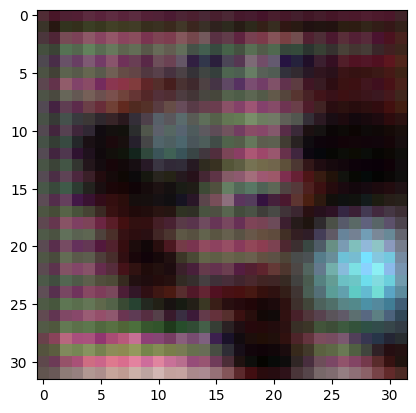

4/4 [==============================] - 1s 266ms/step
Batch Images-> 100


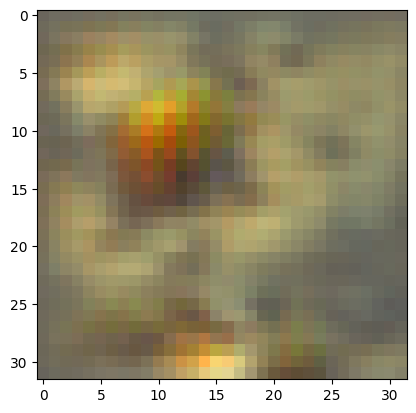

4/4 [==============================] - 1s 291ms/step
Batch Images-> 200


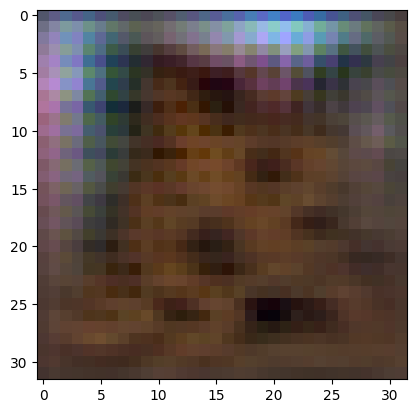

4/4 [==============================] - 1s 209ms/step
Batch Images-> 300


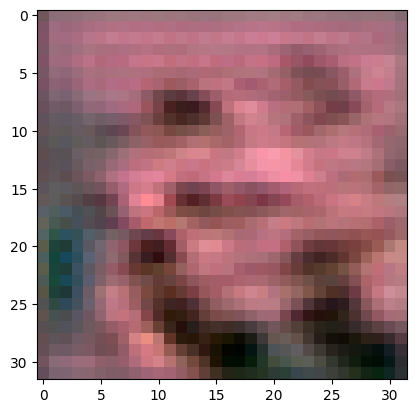

4/4 [==============================] - 1s 216ms/step
Batch Images-> 400


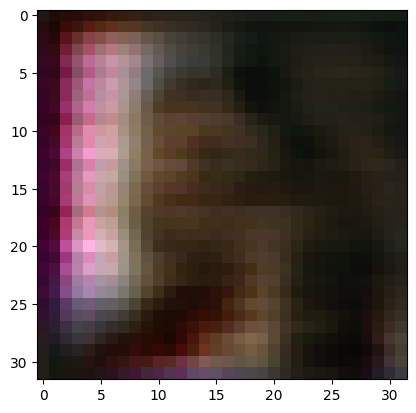

4/4 [==============================] - 1s 125ms/step
Batch Images-> 500


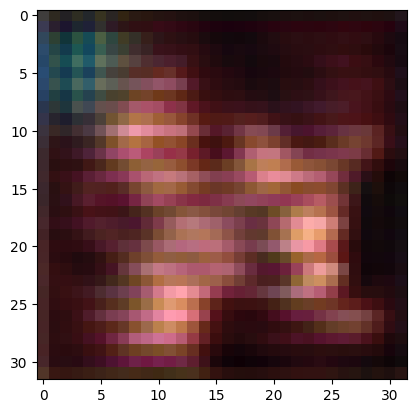

4/4 [==============================] - 1s 149ms/step
Batch Images-> 600


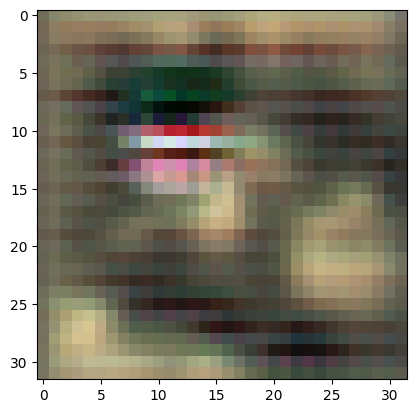

4/4 [==============================] - 1s 132ms/step
Batch Images-> 700


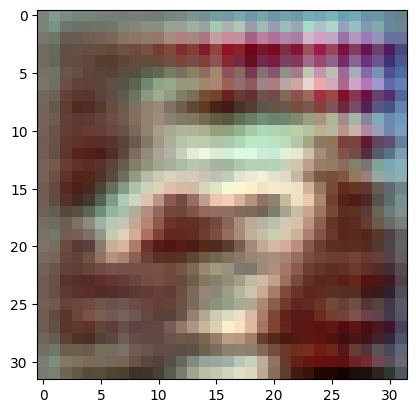

4/4 [==============================] - 1s 131ms/step
Batch Images-> 800


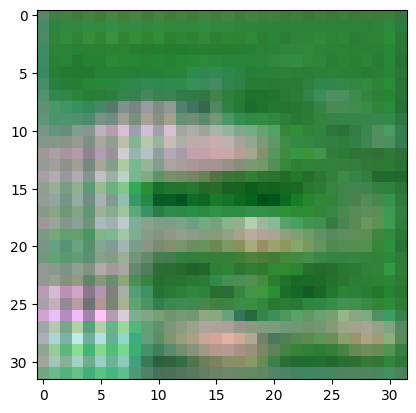

4/4 [==============================] - 0s 120ms/step
Batch Images-> 900


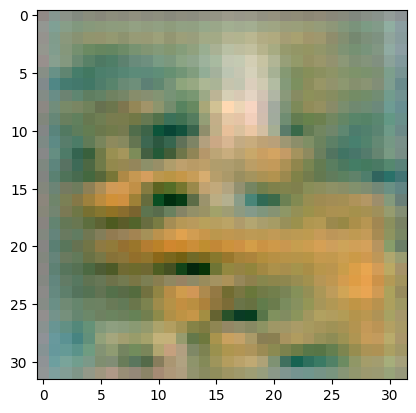

4/4 [==============================] - 1s 129ms/step
Batch Images-> 1000


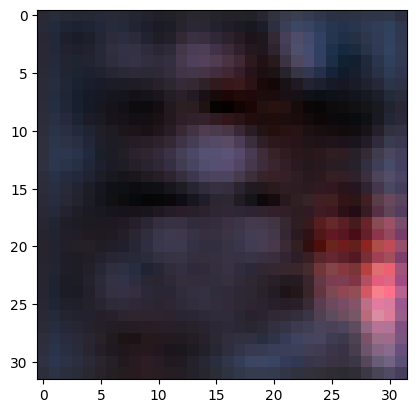

4/4 [==============================] - 1s 125ms/step
Batch Images-> 1100


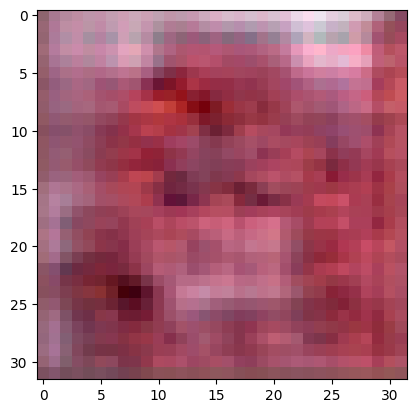

4/4 [==============================] - 1s 249ms/step
Batch Images-> 1200


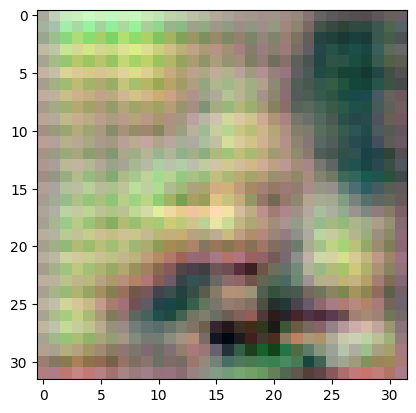

4/4 [==============================] - 1s 201ms/step
Batch Images-> 1300


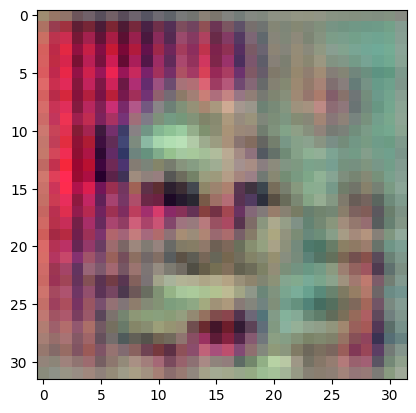

4/4 [==============================] - 1s 207ms/step
Batch Images-> 1400


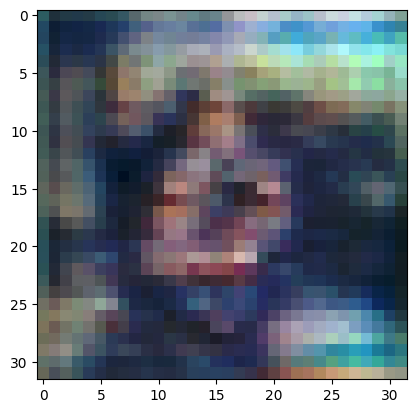

4/4 [==============================] - 1s 136ms/step
Batch Images-> 1500


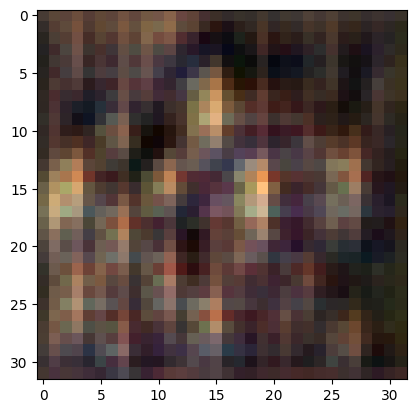

4/4 [==============================] - 0s 95ms/step
No of Epochs-> 4
4/4 [==============================] - 1s 125ms/step
Batch Images-> 0


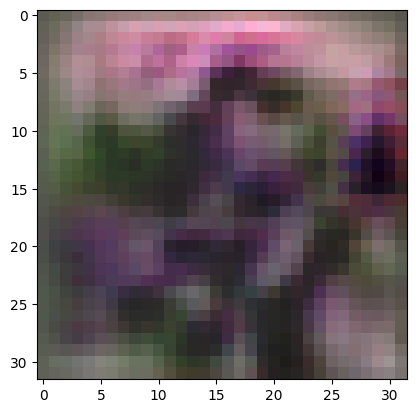

4/4 [==============================] - 1s 131ms/step
Batch Images-> 100


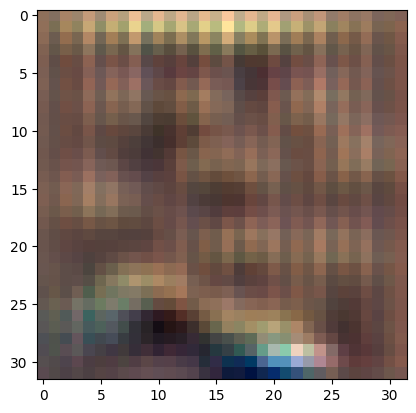

4/4 [==============================] - 1s 130ms/step
Batch Images-> 200


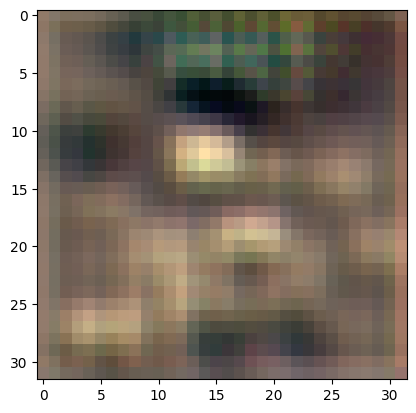

4/4 [==============================] - 1s 142ms/step
Batch Images-> 300


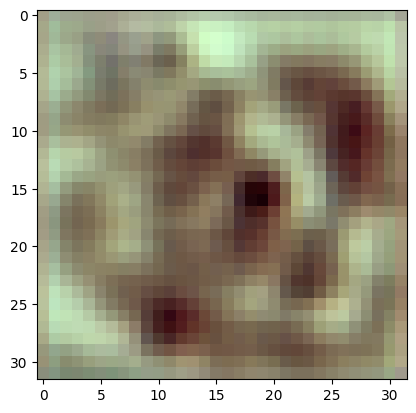

4/4 [==============================] - 1s 129ms/step
Batch Images-> 400


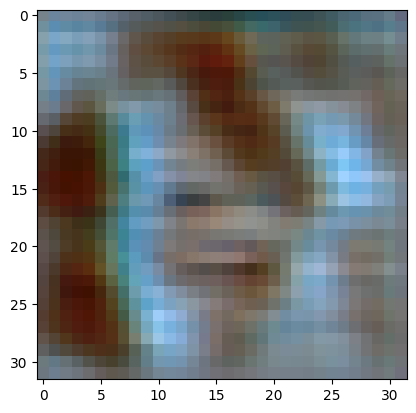

4/4 [==============================] - 1s 138ms/step
Batch Images-> 500


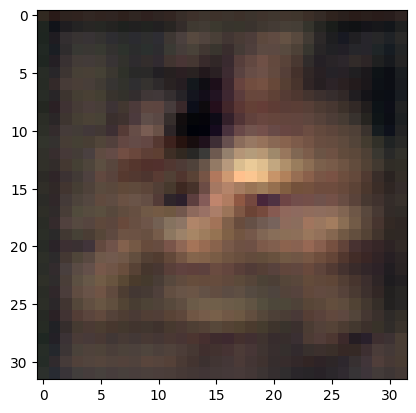

4/4 [==============================] - 1s 129ms/step
Batch Images-> 600


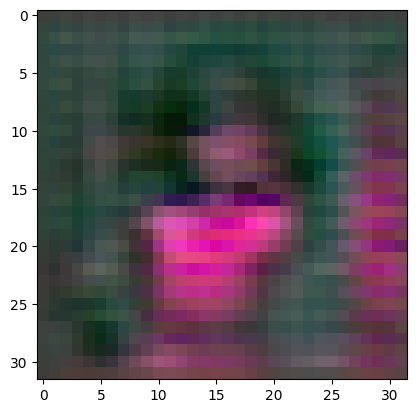

4/4 [==============================] - 1s 133ms/step
Batch Images-> 700


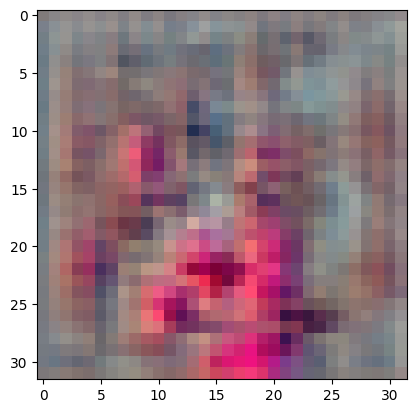

4/4 [==============================] - 1s 131ms/step
Batch Images-> 800


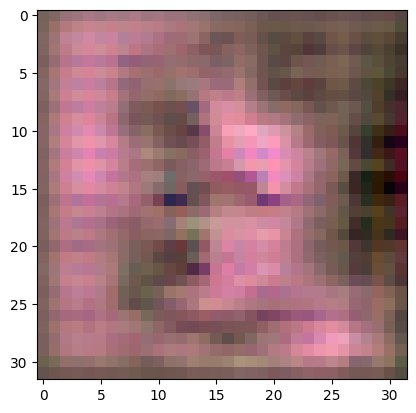

4/4 [==============================] - 1s 128ms/step
Batch Images-> 900


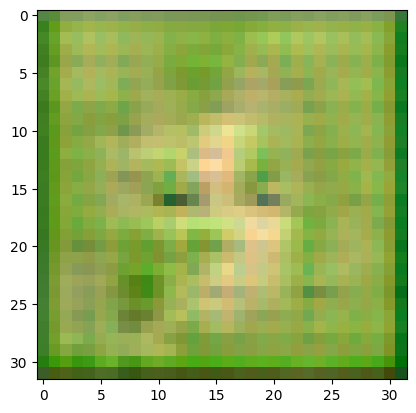

4/4 [==============================] - 1s 129ms/step
Batch Images-> 1000


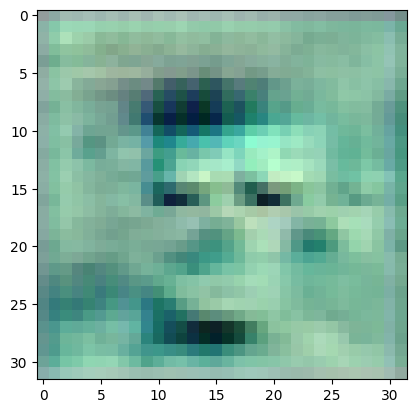

4/4 [==============================] - 1s 134ms/step
Batch Images-> 1100


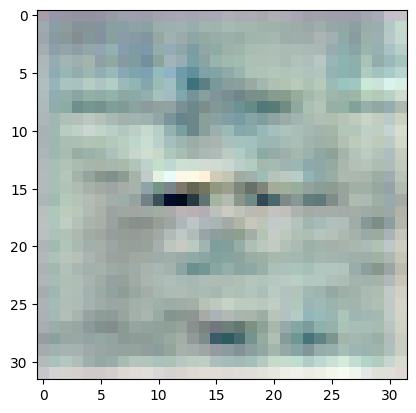

4/4 [==============================] - 1s 126ms/step
Batch Images-> 1200


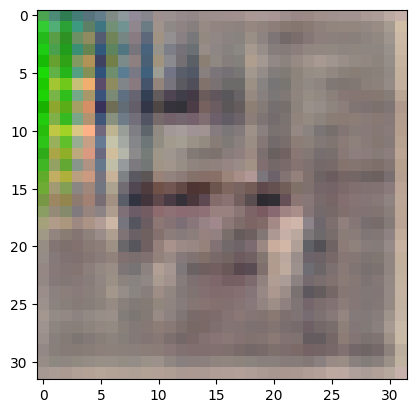

4/4 [==============================] - 1s 132ms/step
Batch Images-> 1300


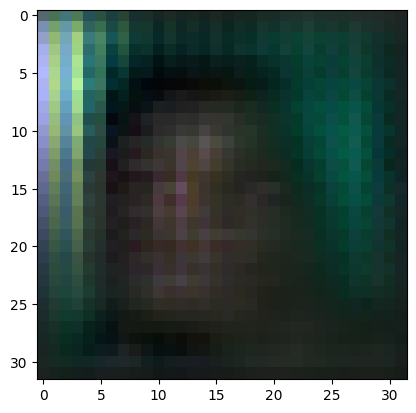

4/4 [==============================] - 1s 129ms/step
Batch Images-> 1400


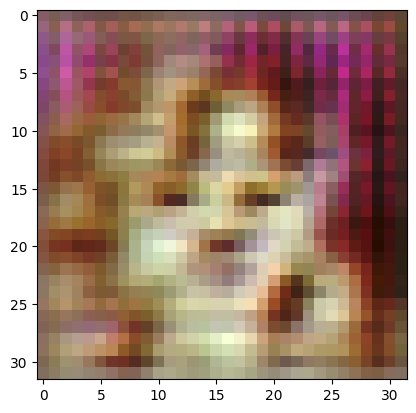

4/4 [==============================] - 1s 137ms/step
Batch Images-> 1500


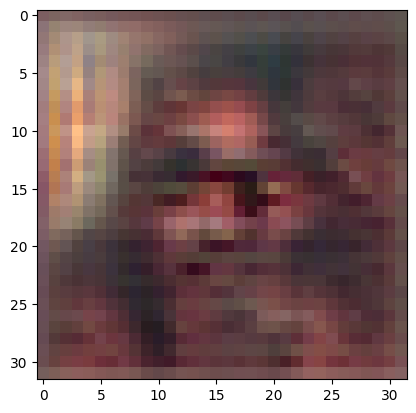

4/4 [==============================] - 0s 101ms/step
No of Epochs-> 5
4/4 [==============================] - 1s 129ms/step
Batch Images-> 0


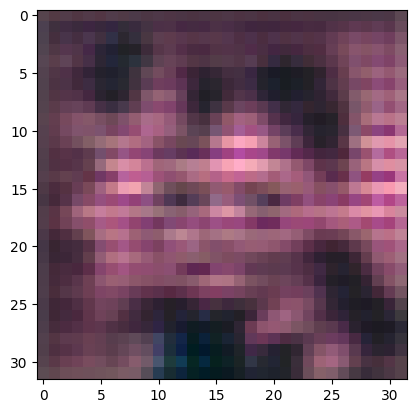

4/4 [==============================] - 1s 131ms/step
Batch Images-> 100


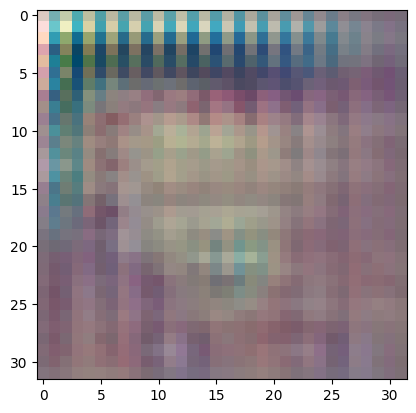

4/4 [==============================] - 1s 128ms/step
Batch Images-> 200


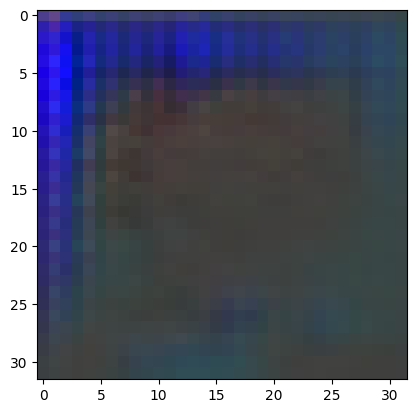

4/4 [==============================] - 1s 128ms/step
Batch Images-> 300


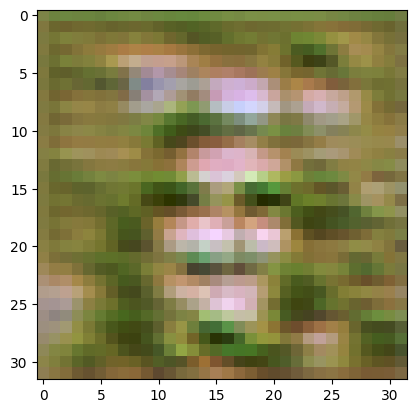

4/4 [==============================] - 1s 132ms/step
Batch Images-> 400


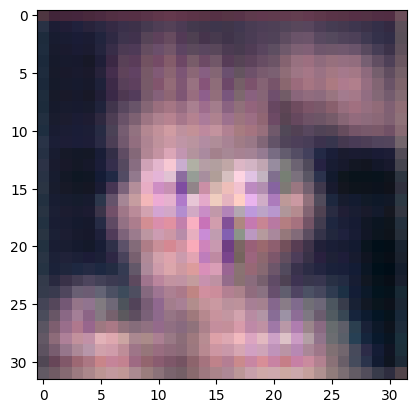

4/4 [==============================] - 1s 140ms/step
Batch Images-> 500


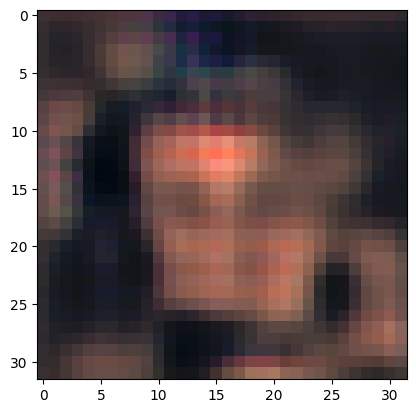

4/4 [==============================] - 1s 227ms/step
Batch Images-> 600


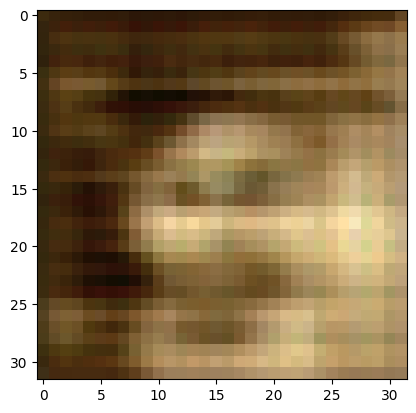

4/4 [==============================] - 1s 234ms/step
Batch Images-> 700


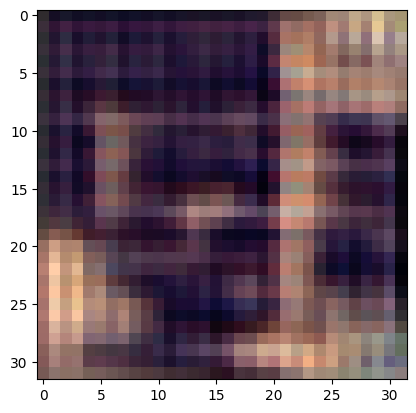

4/4 [==============================] - 1s 141ms/step
Batch Images-> 800


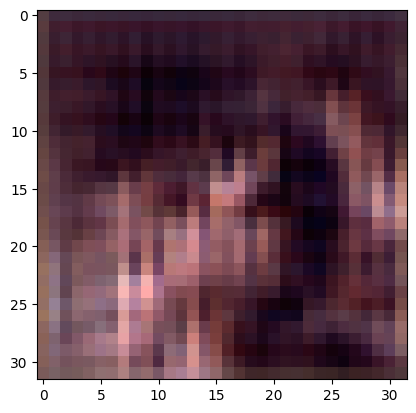

4/4 [==============================] - 1s 129ms/step
Batch Images-> 900


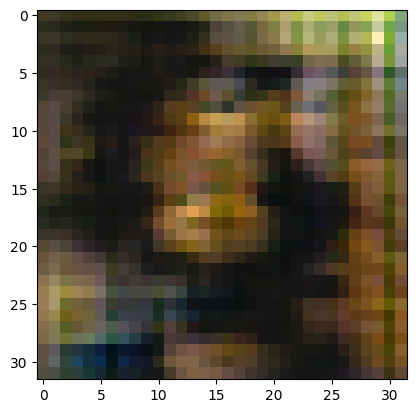

4/4 [==============================] - 1s 147ms/step
Batch Images-> 1000


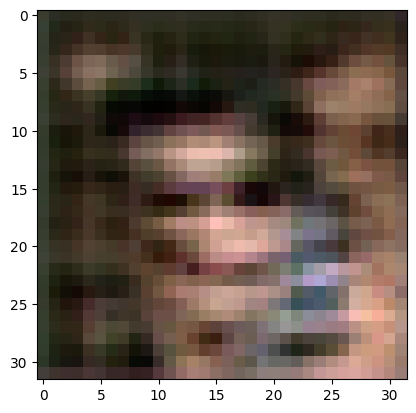

4/4 [==============================] - 1s 127ms/step
Batch Images-> 1100


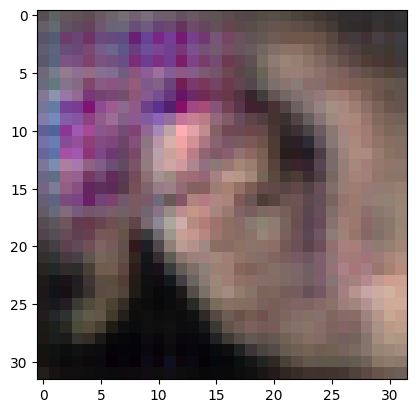

4/4 [==============================] - 0s 122ms/step
Batch Images-> 1200


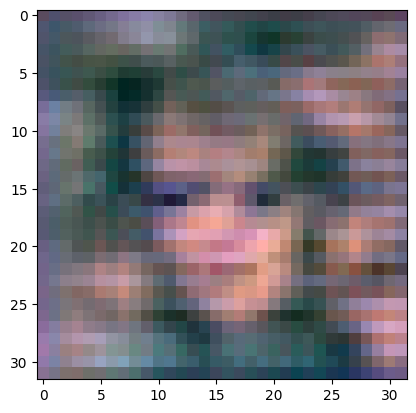

4/4 [==============================] - 1s 130ms/step
Batch Images-> 1300


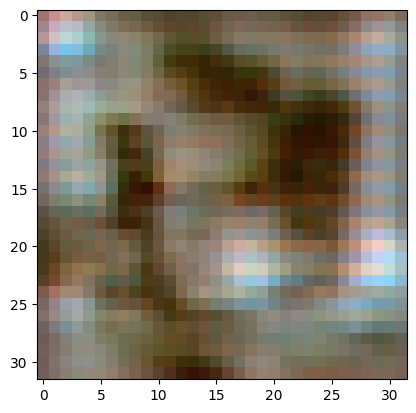

4/4 [==============================] - 1s 126ms/step
Batch Images-> 1400


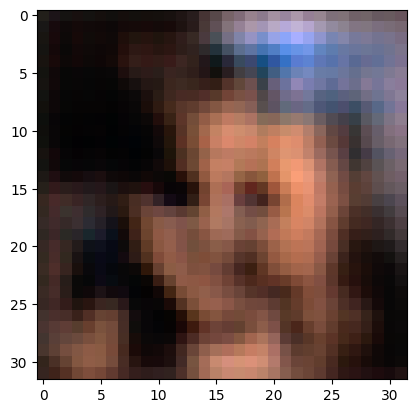

4/4 [==============================] - 1s 150ms/step
Batch Images-> 1500


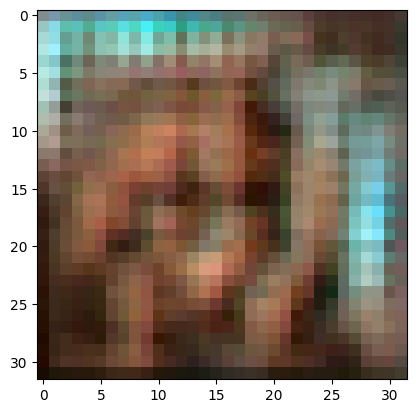

4/4 [==============================] - 0s 103ms/step
No of Epochs-> 6
4/4 [==============================] - 0s 116ms/step
Batch Images-> 0


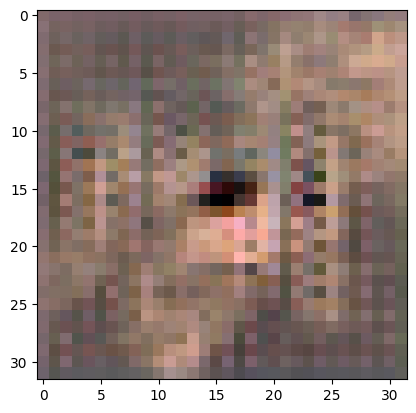

4/4 [==============================] - 1s 211ms/step
Batch Images-> 100


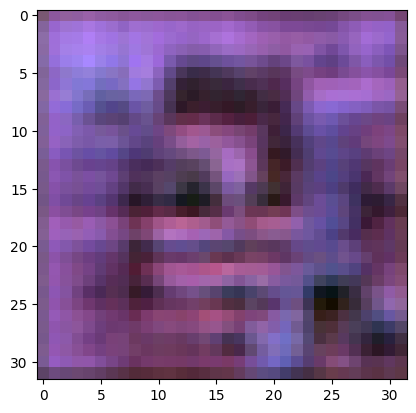

4/4 [==============================] - 1s 221ms/step
Batch Images-> 200


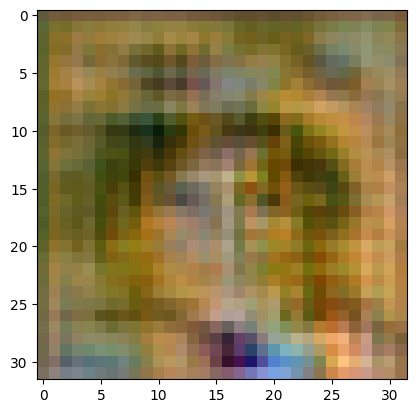

4/4 [==============================] - 1s 222ms/step


: 

In [14]:
for epochs in range(20):
    print(f'No of Epochs-> {epochs}')
    for i,batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])
        if i%100==0:
            print(f'Batch Images-> {i}')
            PATH = '/home/ananthu/machine_learning/human_face-_generation/generate_face'
            generate_and_save_image(path = f'{PATH}/epochs_{epochs}batch_{i}.jpg')